# Loan Prediction

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
plt.rc("font", size=14)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from scipy.stats import uniform



In [2]:
# read files
df_train_ori = pd.read_csv("train_u6lujuX_CVtuZ9i.csv")
df_test_ori = pd.read_csv("test_Y3wMUE5_7gLdaTN.csv")
#print(df_train_ori.count())
#print(df_test_ori.count())
df = pd.concat([df_train_ori, df_test_ori],sort=False,keys=['train', 'test'])
#df[0:614]
#df[614:981]


In [3]:
count_aprov = len(df[df['Loan_Status']=='Y'])
count_not_aprov = len(df[df['Loan_Status']=='N'])
pct_of_aprov = count_aprov/(count_aprov+count_not_aprov)
print("percentage of aproved is", pct_of_aprov*100)
pct_of_not_aprov = count_not_aprov/(count_aprov+count_not_aprov)
print("percentage of not aproved", pct_of_not_aprov*100)

percentage of aproved is 68.72964169381108
percentage of not aproved 31.27035830618892


In [4]:
df.groupby(['Loan_Status']).mean()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Loan_Status,,,,,
N,5446.078125,1877.807292,151.220994,344.064516,0.541899
Y,5384.068720,1504.516398,144.294404,341.072464,0.981818


In [5]:
df.groupby(['Loan_Status','Gender']).count()

Loan_ID  Married  Dependents  Education  Self_Employed  \
Loan_Status Gender                                                           
N           Female       37       37          36         37             35   
            Male        150      150         145        150            143   
Y           Female       75       74          73         75             69   
            Male        339      337         332        339            322   

                    ApplicantIncome  CoapplicantIncome  LoanAmount  \
Loan_Status Gender                                                   
N           Female               37                 37          36   
            Male                150                150         140   
Y           Female               75                 75          73   
            Male                339                339         330   

                    Loan_Amount_Term  Credit_History  Property_Area  
Loan_Status Gender                                                   
N           Female                36              36             37  
            Male                 145             138            150  
Y           Female                73              65             75  
            Male                 333             313            339

In [6]:
df.groupby(['Loan_Status','Married']).count()

Loan_ID  Gender  Dependents  Education  Self_Employed  \
Loan_Status Married                                                          
N           No            79      78          77         79             75   
            Yes          113     109         109        113            108   
Y           No           134     132         132        134            124   
            Yes          285     279         281        285            272   

                     ApplicantIncome  CoapplicantIncome  LoanAmount  \
Loan_Status Married                                                   
N           No                    79                 79          75   
            Yes                  113                113         106   
Y           No                   134                134         131   
            Yes                  285                285         278   

                     Loan_Amount_Term  Credit_History  Property_Area  
Loan_Status Married                                                   
N           No                     77              74             79  
            Yes                   109             105            113  
Y           No                    131             125            134  
            Yes                   280             257            285

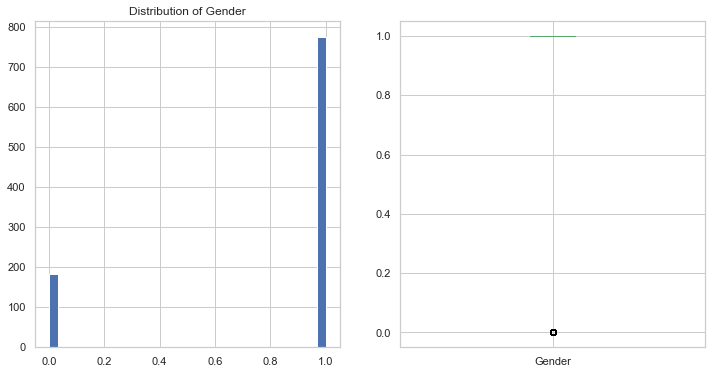

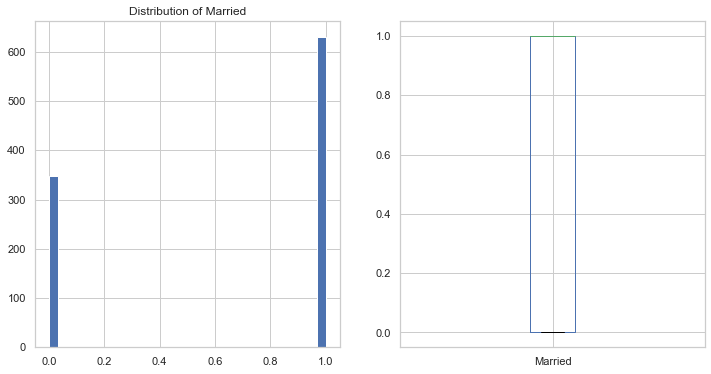

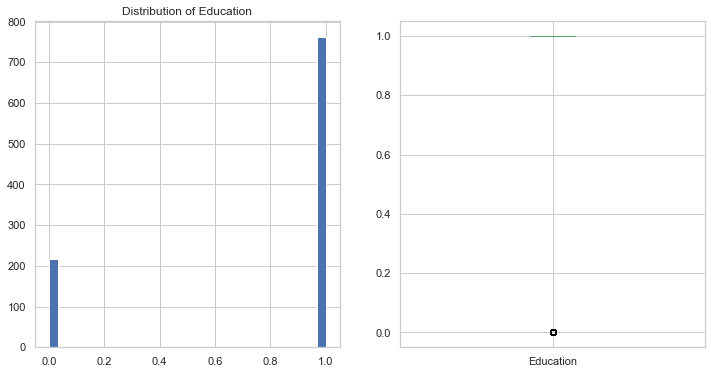

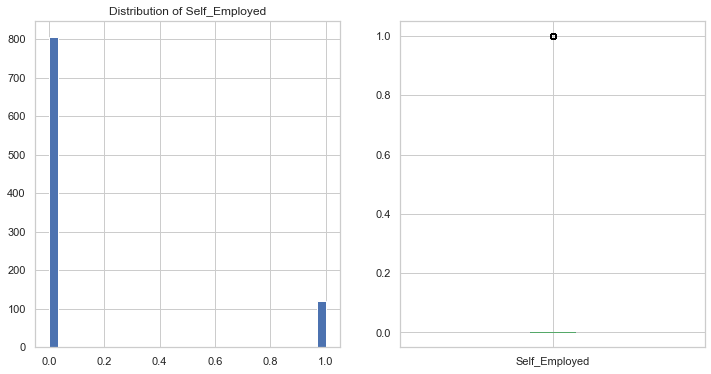

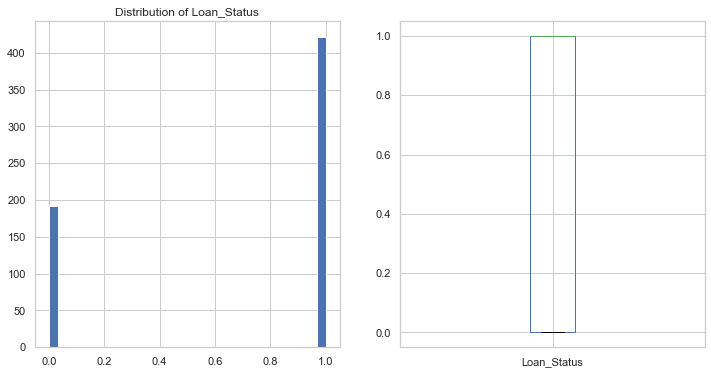

In [7]:
# Replace categorical values
df['Gender'] = df.Gender.replace('Male', 1)
df['Gender'] = df.Gender.replace('Female', 0)
df['Married'] = df.Married.replace('Yes', 1)
df['Married'] = df.Married.replace('No', 0)
df['Education'] = df.Education.replace('Graduate', 1)
df['Education'] = df.Education.replace('Not Graduate', 0)
df['Self_Employed'] = df.Self_Employed.replace('Yes', 1)
df['Self_Employed'] = df.Self_Employed.replace('No', 0)
df['Loan_Status'] = df.Loan_Status.replace('N', 0)
df['Loan_Status'] = df.Loan_Status.replace('Y', 1)
columns = ['Gender','Married', 'Education', 'Self_Employed','Loan_Status']
for col in columns:
    f, axes = plt.subplots(1, 2, figsize=(12, 6))
    df[col].hist(bins = 30, ax = axes[0])
    axes[0].set_title('Distribution of '+ col)
    df.boxplot(column = col, ax = axes[1])
    plt.show()

In [8]:
# categorical missing values
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])
df['Education'] = df['Education'].fillna(df['Education'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])
df['Property_Area'] = df['Property_Area'].fillna(df['Property_Area'].mode()[0])
# continuous missing values
df['ApplicantIncome'] = df['ApplicantIncome'].fillna(df['ApplicantIncome'].mean())
df['CoapplicantIncome'] = df['CoapplicantIncome'].fillna(df['CoapplicantIncome'].mean())
#df.loc[ (pd.isnull(df['Credit_History'])) & (df['Loan_Status'] == 1), 'Credit_History'] = 1
#df.loc[ (pd.isnull(df['Credit_History'])) & (df['Loan_Status'] == 0), 'Credit_History'] = 0
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean())

In [9]:
df.count()
df.loc[df['Gender'].isna()]

,,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status


In [10]:
# dummy variables
#cat_vars=['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Property_Area']
cat_vars=['Dependents','Property_Area']
for var in cat_vars:
    cat_list = pd.get_dummies(df[var], prefix=var)
    df1=df.join(cat_list)
    df=df1

In [11]:
# remove columns
data_vars=df.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
df_final=df[to_keep]
del df_final['Loan_ID']
df_final.columns.values

array(['Gender', 'Married', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status',
       'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Property_Area_Rural', 'Property_Area_Semiurban',
       'Property_Area_Urban'], dtype=object)

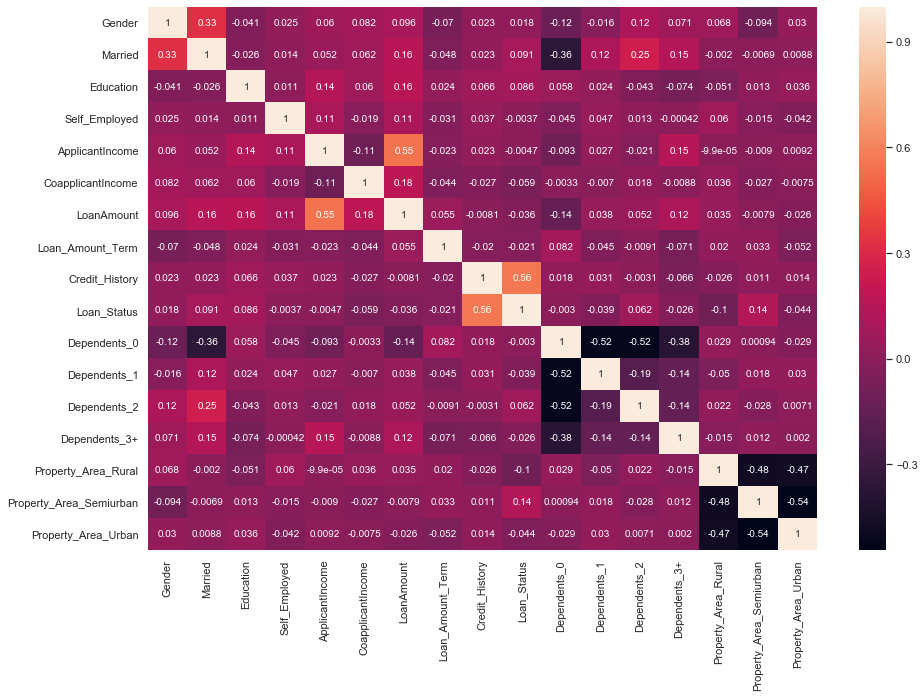

In [12]:
# compute the correlation
corr = df_final.corr(method='pearson')
plt.figure(figsize = (15, 10))
sns.heatmap(corr, annot = True)

/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


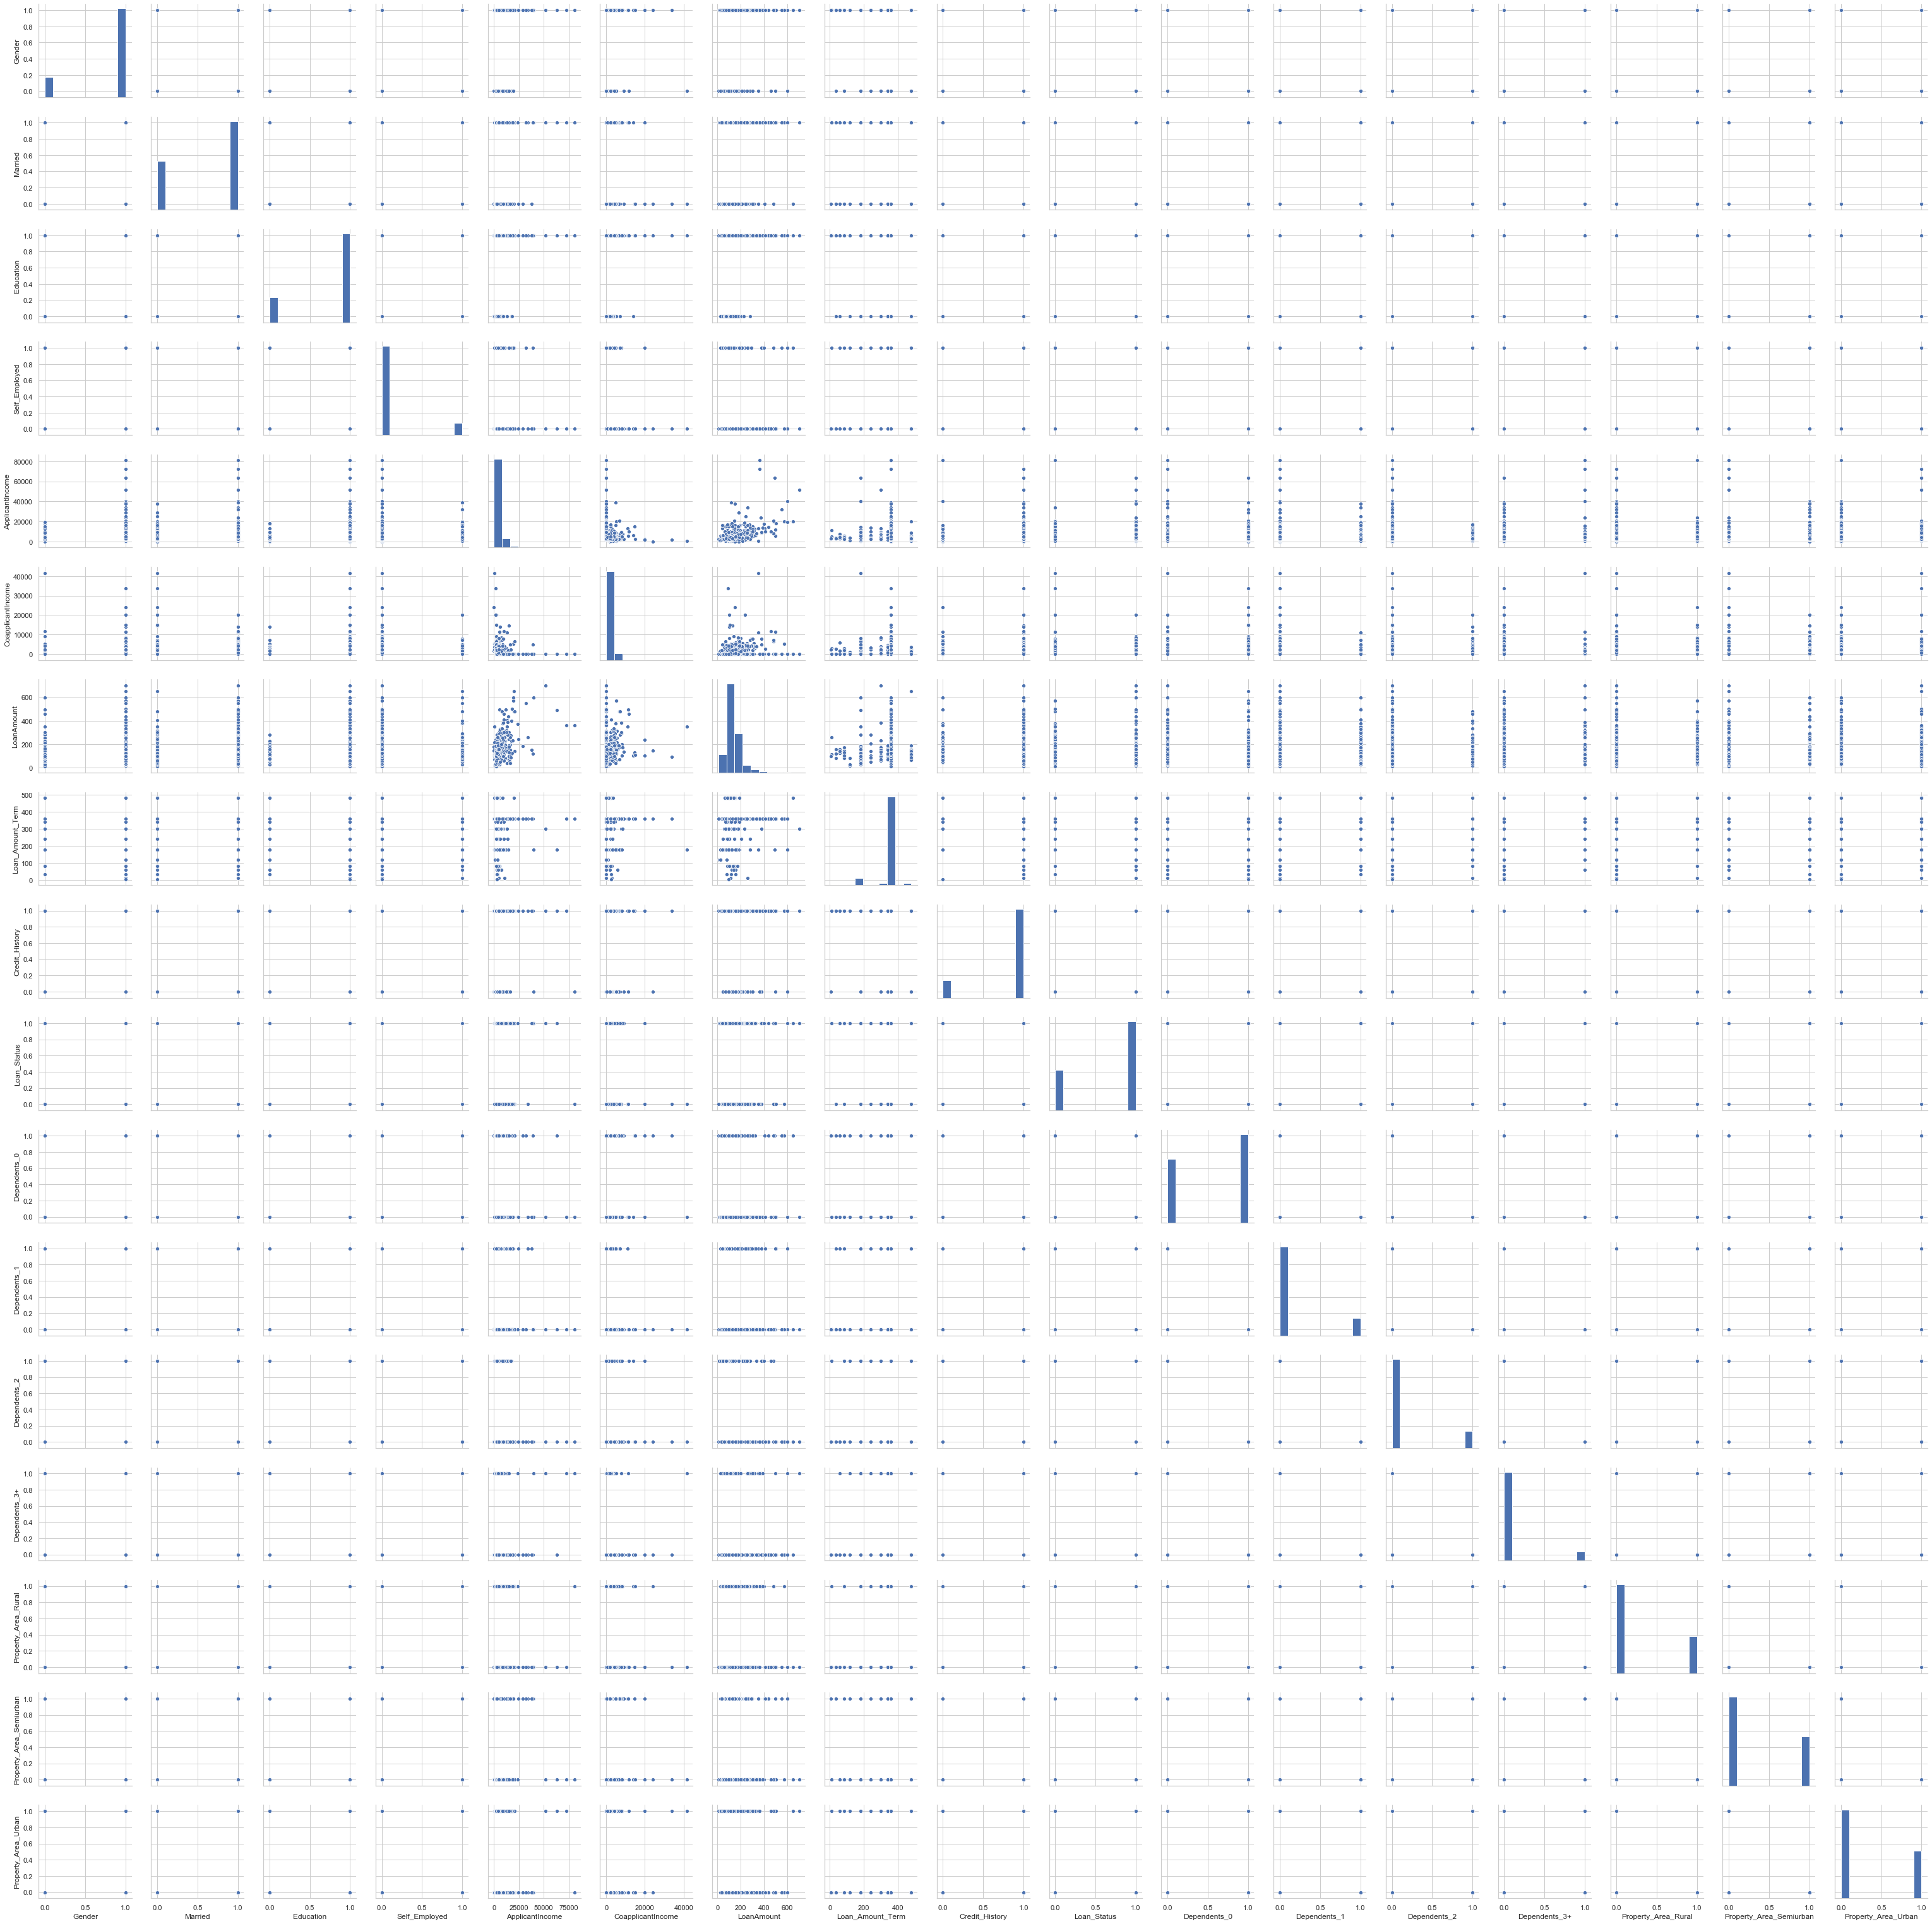

In [13]:
sns.pairplot(df_final)

In [14]:
# remove outliers
numeric_columns = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']
for col in columns:
    elements = df_final[col]
    mean = elements.mean()
    sd = elements.std()
    df_final.loc[((df_final[col] > mean + 3*sd) | (df_final[col] < mean - 3*sd)),col] = mean


/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [15]:
# defines a predefined scaler 
def scale_numeric(data, numeric_columns, scaler):
    for col in numeric_columns:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1,1))
    return data

# we can now define the scaler we want to use and apply it to our dataset
# a good exercise would be to research what StandardScaler does - it is from the scikit learn library
scaler = StandardScaler()
df_final = scale_numeric(df_final, numeric_columns,scaler)
# here we can see the result
df_final[0:10]

/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Gender  Married  Education  Self_Employed  ApplicantIncome  \
train 0     1.0      0.0        1.0            0.0         0.117565   
      1     1.0      1.0        1.0            0.0        -0.104844   
      2     1.0      1.0        1.0            1.0        -0.382944   
      3     1.0      1.0        0.0            0.0        -0.456202   
      4     1.0      0.0        1.0            0.0         0.144093   
      5     1.0      1.0        1.0            1.0         0.041672   
      6     1.0      1.0        0.0            0.0        -0.500122   
      7     1.0      1.0        1.0            0.0        -0.376620   
      8     1.0      1.0        1.0            0.0        -0.206211   
      9     1.0      1.0        1.0            0.0         1.345913   

         CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
train 0          -0.589506    0.000000          0.276368             1.0   
      1          -0.034561   -0.190168          0.276368             1.0   
      2          -0.589506   -1.002656          0.276368             1.0   
      3           0.278239   -0.295006          0.276368             1.0   
      4          -0.589506   -0.019808          0.276368             1.0   
      5           0.954624    1.631377          0.276368             1.0   
      6          -0.031617   -0.622622          0.276368             1.0   
      7           0.331967    0.202971          0.276368             0.0   
      8          -0.027937    0.334017          0.276368             1.0   
      9           3.446725    2.705957          0.276368             1.0   

         Loan_Status  Dependents_0  Dependents_1  Dependents_2  Dependents_3+  \
train 0          1.0             1             0             0              0   
      1          0.0             0             1             0              0   
      2          1.0             1             0             0              0   
      3          1.0             1             0             0              0   
      4          1.0             1             0             0              0   
      5          1.0             0             0             1              0   
      6          1.0             1             0             0              0   
      7          0.0             0             0             0              1   
      8          1.0             0             0             1              0   
      9          0.0             0             1             0              0   

         Property_Area_Rural  Property_Area_Semiurban  Property_Area_Urban  
train 0                    0                        0                    1  
      1                    1                        0                    0  
      2                    0                        0                    1  
      3                    0                        0                    1  
      4                    0                        0                    1  
      5                    0                        0                    1  
      6                    0                        0                    1  
      7                    0                        1                    0  
      8                    0                        0                    1  
      9                    0                        1                    0

In [16]:
# Credit_History missing values - Random Forest
#df.loc[ (pd.isnull(df['Credit_History'])) & (df['Loan_Status'] == 1), 'Credit_History'] = 1
#df.loc[ (pd.isnull(df['Credit_History'])) & (df['Loan_Status'] == 0), 'Credit_History'] = 0
X_train_ch = df_final.loc[ (pd.notnull(df_final['Credit_History']) & pd.notnull(df_final['Loan_Status'])) , df_final.columns != 'Credit_History']
y_train_ch = df_final.loc[ (pd.notnull(df_final['Credit_History']) & pd.notnull(df_final['Loan_Status'])) , 'Credit_History']
X_test_ch = df_final.loc[ (pd.isnull(df_final['Credit_History']) & pd.notnull(df_final['Loan_Status'])) , df_final.columns != 'Credit_History']
rnd_clf = RandomForestClassifier()
#X_train_ch.isnull().any()
rnd_clf.fit(X_train_ch, y_train_ch)
ch_pred = rnd_clf.predict(X_test_ch)
#print(X_test_ch['Loan_Status'])
#ch_pred
#X_test_ch 
df_final.loc[ (pd.isnull(df_final['Credit_History']) & pd.notnull(df_final['Loan_Status'])) , 'Credit_History'] = ch_pred
#
X_train_ch = df_final.loc[ (pd.notnull(df_final['Credit_History'])) , ~df_final.columns.isin(['Credit_History','Loan_Status'])]
y_train_ch = df_final.loc[ (pd.notnull(df_final['Credit_History'])) , 'Credit_History']
X_test_ch = df_final.loc[ (pd.isnull(df_final['Credit_History'])) , ~df_final.columns.isin(['Credit_History','Loan_Status'])]
rnd_clf = RandomForestClassifier()
#X_train_ch.isnull().any()
rnd_clf.fit(X_train_ch, y_train_ch)
ch_pred = rnd_clf.predict(X_test_ch)
#print(X_test_ch['Loan_Status'])
#ch_pred
#X_test_ch 
df_final.loc[ (pd.isnull(df_final['Credit_History'])) , 'Credit_History'] = ch_pred

/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is tr

In [17]:
# Because our classes are not absolutely equal in number, we can apply stratification to the split
# and be sure that the ratio of the classes in both train and test will be the same
df_train = df_final.loc['train']
X = df_train.loc[:, df_train.columns != 'Loan_Status']
#y = df_final.loc[:, df_final.columns == 'Loan_Status']
y = df_train.Loan_Status
y = y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle=True)



In [18]:
# we can get shape of test and training sets
print('Training Set:')
print('Number of datapoints: ', X_train.shape[0])
print('Number of features: ', X_train.shape[1])
print('\n')
print('Test Set:')
print('Number of datapoints: ', X_test.shape[0])
print('Number of features: ', X_test.shape[1])
# and we can verify the stratifications 
print('Labels counts in y:', np.bincount(y))
print('Percentage of class zeroes in class_y',np.round(np.bincount(y)[0]/len(y)*100))
print("\n")
print('Labels counts in y_train:', np.bincount(y_train))
print('Percentage of class zeroes in y_train',np.round(np.bincount(y_train)[0]/len(y_train) *100))
print("\n")
print('Labels counts in y_test:', np.bincount(y_test))
print('Percentage of class zeroes in y_test',np.round(np.bincount(y_test)[0]/len(y_test)*100))

Training Set:
Number of datapoints:  491
Number of features:  16


Test Set:
Number of datapoints:  123
Number of features:  16
Labels counts in y: [192 422]
Percentage of class zeroes in class_y 31.0


Labels counts in y_train: [154 337]
Percentage of class zeroes in y_train 31.0


Labels counts in y_test: [38 85]
Percentage of class zeroes in y_test 31.0


In [19]:
## we can create a baseline model to benchmark our other estimators against
## this can be a simple estimator or we can use a dummy estimator to make predictions in a random manner
# this creates our dummy classifier, and the value we pass in to the strategy parameter dtermn
dummy = DummyClassifier(strategy='uniform',random_state=1)
"""### : Train and Test the Model"""
# "Train" model
dummy.fit(X_train, y_train)
# from this, we can generate a set of predictions on our unseen features, X_test
dummy_predictions = dummy.predict(X_test)

In [20]:
# Choose an evaluation metric
def evaluate(y_test, y_pred):
    # this block of code returns all the metrics we are interested in 
    accuracy = metrics.accuracy_score(y_test,y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred)
    print ("Accuracy", accuracy)
    print ('F1 score: ', f1)
    print ('ROC_AUC: ' , auc)

    
evaluate(y_test, dummy_predictions)

Accuracy 0.5284552845528455
F1 score:  0.618421052631579
ROC_AUC:  0.513312693498452


In [21]:
# instantiate logistic regression classifier
logistic = LogisticRegression()
cross_val_score(logistic, X, y, cv=5, scoring="f1")

/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: 

array([0.89361702, 0.84536082, 0.86315789, 0.91208791, 0.89247312])

In [22]:
# ensemble of three models
rnd_clf = RandomForestClassifier()
dt_clf = DecisionTreeClassifier()
voting_clf = VotingClassifier(estimators=[('lr', logistic), ('rf', rnd_clf), ('dc', dt_clf)],voting='soft')
for clf in (logistic, rnd_clf, dt_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

penalty = ['l1', 'l2']
C = uniform(loc=0, scale=4)
hyperparameters = dict(C=C, penalty=penalty)
randomizedsearch = RandomizedSearchCV(logistic,hyperparameters, random_state=1,n_iter=100, cv=5, verbose=0, n_jobs=-1)
best_model = randomizedsearch.fit(X, y)
best_predictions = best_model.predict(X_test)
evaluate(y_test, best_predictions)
cross_val_score(best_model, X, y, cv=5,scoring="accuracy").mean()


/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression 0.8292682926829268
RandomForestClassifier 0.7642276422764228
DecisionTreeClassifier 0.7723577235772358
VotingClassifier 0.8130081300813008


/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy 0.8455284552845529
F1 score:  0.8983957219251337
ROC_AUC:  0.7572755417956657


/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/lemos/mini

0.8177154944473823

In [23]:
# result
df_test = df_final.loc['test']
X_test_final = df_test.loc[:, df_test.columns != 'Loan_Status']
predictions = best_model.predict(X_test_final)
df_result = pd.DataFrame(data=predictions,columns=['Loan_Status']) 
df_result['Loan_Status'] = df_result['Loan_Status'].apply(str)
df_result['Loan_Status'] = df_result.Loan_Status.replace('0', 'N')
df_result['Loan_Status'] = df_result.Loan_Status.replace('1', 'Y')
df_result['Loan_ID'] = df_test_ori['Loan_ID']
df_result.to_csv('loanPrediction.csv',index=False)
